In [ ]:
### T008_Protein data acquisition: Protein Data Bank (PDB)

In [1]:
!pip install biotite
!pip install pypdb
!pip install redo
!pip install requests-cache
!pip install https://github.com/volkamerlab/opencadd/archive/master.tar.gz

import collections
import logging
import pathlib
import time
import warnings
import datetime

import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from tqdm.auto import tqdm
import redo
import requests_cache
import nglview
import pypdb
import biotite.database.rcsb as rcsb
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools

from opencadd.structure.superposition.api import align, METHODS
from opencadd.structure.core import Structure

# Disable some unneeded warnings
logger = logging.getLogger("opencadd")
logger.setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

# Cache requests -- this will speed up repeated queries to PDB
requests_cache.install_cache("rcsb_pdb", backend="memory")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.1/32.1 MB 39.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for redo: filename=redo-2.0.4-py2.py3-none-any.whl size=11924 sha256=84b68cfb14b7a8216235a2f5ad5d12a8803f0c2cc0f25dc02b9318b9254fbbe4
  Stored in directory: /home/jovyan/.cache/pip/wheels/26/e4/ba/8fad8d847e752ab9909525f10ff986c513ef5aada8ffa58ee0
Successfully built redo
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 KB 3.1 MB/s eta 0:00:00
  Using cached url_normalize-1.4.3-py2.py3-none-any.whl (6.8 kB)
  Using cached https://github.com/volkamerlab/opencadd/archive/master.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for opencadd: filename=opencadd-0+unknown-py3-none-any.whl size=2726280 sha256=b78be3c8e5de3c09bc45a61cedfd7d1c4208bb3d56747030b8ba1c2109ad8e2b
  Stored in directory: /tmp/pip-ephem-wheel-cache-9vgiaurd/whee

/opt/conda/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
# Define paths
HERE = pathlib.Path(_dh[-1])
DATA = HERE / "data"

In [ ]:
### Select a query protein

In [4]:
uniprot_id = "Q07820"

In [ ]:
### Get the number of PDB entries for a query protein

In [5]:
query_by_uniprot_id = rcsb.FieldQuery(
    "rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession",
    exact_match=uniprot_id,
)
today = datetime.datetime.now()
print(
    f"Number of structures on {today.year}-{today.month}-{today.day}: {rcsb.count(query_by_uniprot_id)}"
)

Number of structures on 2022-10-27: 112


In [6]:
# Define lists for years and number of structures available in a given year
years = range(1971, datetime.datetime.now().year)
n_structures = []

for year in years:
    # Set latest date for allowed deposition
    before_deposition_date = f"{year}-12-31T23:59:59Z"
    # Set up query for structures deposited latest at given date
    query_by_deposition_date = rcsb.FieldQuery(
        "rcsb_accession_info.deposit_date", less_or_equal=before_deposition_date
    )
    # Set up combined query
    query = rcsb.CompositeQuery(
        [query_by_uniprot_id, query_by_deposition_date],
        "and",
    )
    # Count matching structures and add to list
    n_structures.append(rcsb.count(query))
    # wait shortly to not overload the API
    time.sleep(0.1)

In [ ]:
### Plot the results!

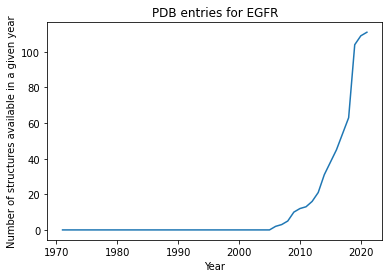

In [7]:
plt.plot(years, n_structures)
plt.title("PDB entries for EGFR")
plt.xlabel("Year")
plt.ylabel("Number of structures available in a given year");

In [ ]:
### Define certain conditions to fullfill PDB entries

In [8]:
uniprot_id = "Q07820"
before_deposition_date = "2020-01-01T00:00:00Z"
experimental_method = "X-RAY DIFFRACTION"
max_resolution = 3.0
n_chains = 1
min_ligand_molecular_weight = 100.0

In [ ]:
### Set up each query

In [10]:
query_by_uniprot_id = rcsb.FieldQuery(
    "rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession",
    exact_match=uniprot_id,
)
query_by_deposition_date = rcsb.FieldQuery(
    "rcsb_accession_info.deposit_date", less=before_deposition_date
)
query_by_experimental_method = rcsb.FieldQuery("exptl.method", exact_match=experimental_method)
query_by_resolution = rcsb.FieldQuery(
    "rcsb_entry_info.resolution_combined", less_or_equal=max_resolution
)
query_by_polymer_count = rcsb.FieldQuery(
    "rcsb_entry_info.deposited_polymer_entity_instance_count", equals=n_chains
)
query_by_ligand_mw = rcsb.FieldQuery(
    "chem_comp.formula_weight", molecular_definition=True, greater=min_ligand_molecular_weight
)

In [ ]:
### Perform each of the queries alone and check the number of matches per condition

In [11]:
print(f"Number of structures with UniProt ID {uniprot_id}: {rcsb.count(query_by_uniprot_id)}")
time.sleep(0.1)  # wait shortly to not overload the API
print(
    f"Number of structures deposited before {before_deposition_date}: {rcsb.count(query_by_deposition_date)}"
)
time.sleep(0.1)
print(
    f"Number of structures resolved by {experimental_method}: {rcsb.count(query_by_experimental_method)}"
)
time.sleep(0.1)
print(
    f"Number of structures with resolution less than or equal to {max_resolution}: {rcsb.count(query_by_resolution)}"
)
time.sleep(0.1)
print(f"Number of structures with only {n_chains} chain: {rcsb.count(query_by_polymer_count)}")
time.sleep(0.1)
print(
    f"Number of structures with ligand of more than or equal to {min_ligand_molecular_weight} Da: {rcsb.count(query_by_ligand_mw)}"
)

Number of structures with UniProt ID Q07820: 112
Number of structures deposited before 2020-01-01T00:00:00Z: 166329
Number of structures resolved by X-RAY DIFFRACTION: 170006
Number of structures with resolution less than or equal to 3.0: 161903
Number of structures with only 1 chain: 72582
Number of structures with ligand of more than or equal to 100.0 Da: 1197339


In [ ]:
### Combine all queries with the and operator to match only PDB IDs that fulfill all the conditions

In [12]:
query = rcsb.CompositeQuery(
    [
        query_by_uniprot_id,
        query_by_deposition_date,
        query_by_experimental_method,
        query_by_resolution,
        query_by_polymer_count,
        query_by_ligand_mw,
    ],
    "and",
)
pdb_ids = rcsb.search(query)
print(f"Number of matches: {len(pdb_ids)}")
print("Selected PDB IDs:")
print(*pdb_ids)

Number of matches: 34
Selected PDB IDs:
4WMR 4WGI 6QZB 5FC4 6UD2 4WMX 6QXJ 5LOF 4WMW 4WMV 4WMU 4WMT 4WMS 6P3P 6U64 6QFQ 6UDI 6UDT 6UDU 6QYN 6B4U 6QYK 6QYL 6OQD 6OQB 6O6G 6QZ6 6QZ7 6QGD 6QZ5 6UDV 6QYO 6QYP 6QZ8


In [ ]:
### Select PDB entries with the hightest resolution

In [ ]:
### Download the full metadata for selected PDB IDs

In [14]:
@redo.retriable(attempts=10, sleeptime=2)
def describe_one_pdb_id(pdb_id):
    """Fetch meta information from PDB."""
    described = pypdb.describe_pdb(pdb_id)
    if described is None:
        print(f"! Error while fetching {pdb_id}, retrying ...")
        raise ValueError(f"Could not fetch PDB id {pdb_id}")
    return described

pdbs_data = [describe_one_pdb_id(pdb_id) for pdb_id in tqdm(pdb_ids)]

  0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
### Take a look at the metadata of the first PDB IDs

In [15]:
print("\n".join(pdbs_data[0].keys()))

audit_author
cell
citation
diffrn
diffrn_detector
diffrn_radiation
diffrn_source
entry
exptl
exptl_crystal
exptl_crystal_grow
pdbx_audit_revision_details
pdbx_audit_revision_history
pdbx_database_related
pdbx_database_status
pdbx_vrpt_summary
rcsb_accession_info
rcsb_entry_container_identifiers
rcsb_entry_info
rcsb_primary_citation
refine
refine_hist
refine_ls_restr
reflns
reflns_shell
software
struct
struct_keywords
symmetry
rcsb_id


In [16]:
# The "entry" key which contains the PDB ID 
pdbs_data[0]["entry"]

{'id': '4WMR'}

In [17]:
# The "rcsb_entry_info" key which contains amongst others the structure's resolution ("resolution_combined"
pdbs_data[0]["rcsb_entry_info"]

{'assembly_count': 3,
 'branched_entity_count': 0,
 'cis_peptide_count': 0,
 'deposited_atom_count': 1373,
 'deposited_hydrogen_atom_count': 0,
 'deposited_model_count': 1,
 'deposited_modeled_polymer_monomer_count': 150,
 'deposited_nonpolymer_entity_instance_count': 6,
 'deposited_polymer_entity_instance_count': 1,
 'deposited_polymer_monomer_count': 150,
 'deposited_solvent_atom_count': 123,
 'deposited_unmodeled_polymer_monomer_count': 0,
 'diffrn_radiation_wavelength_maximum': 1.54,
 'diffrn_radiation_wavelength_minimum': 1.54,
 'disulfide_bond_count': 0,
 'entity_count': 5,
 'experimental_method': 'X-ray',
 'experimental_method_count': 1,
 'inter_mol_covalent_bond_count': 0,
 'inter_mol_metalic_bond_count': 11,
 'molecular_weight': 18.34,
 'na_polymer_entity_types': 'Other',
 'nonpolymer_bound_components': ['865', 'POP', 'ZN'],
 'nonpolymer_entity_count': 3,
 'nonpolymer_molecular_weight_maximum': 0.63,
 'nonpolymer_molecular_weight_minimum': 0.07,
 'polymer_composition': 'homome

In [ ]:
### Save the resolution per PDB ID as pandas DataFrame, sorted by the resolution in ascending order

In [18]:
resolution = pd.DataFrame(
    [
        [pdb_data["entry"]["id"], pdb_data["rcsb_entry_info"]["resolution_combined"][0]]
        for pdb_data in pdbs_data
    ],
    columns=["pdb_id", "resolution"],
).sort_values(by="resolution", ignore_index=True)
resolution

,pdb_id,resolution
0,6UDV,1.35
1,6OQD,1.48
2,6UDT,1.50
3,5FC4,1.50
4,4WMU,1.55
5,6OQB,1.60
6,6QFQ,1.60
7,6P3P,1.61
8,4WMR,1.70
9,6QXJ,1.70


In [ ]:
### Get metadata of ligands from top structures

In [19]:
# Number of top structures
top_num = 6

selected_pdb_ids = resolution[:top_num]["pdb_id"].to_list()
print(f"Selected PDB IDs: {selected_pdb_ids}")

Selected PDB IDs: ['6UDV', '6OQD', '6UDT', '5FC4', '4WMU', '6OQB']


In [20]:
# Contain ligands in the orthosteric binding pocket
selected_pdb_ids = ["5UG9", "5HG8", "5UG8", "5UGC"]
print(f"Selected PDB IDs (frozen set): {selected_pdb_ids}")

Selected PDB IDs (frozen set): ['5UG9', '5HG8', '5UG8', '5UGC']


In [ ]:
### Fetch the PDB information and store as csv file

In [21]:
def get_ligands(pdb_id):
    """
    RCSB has not provided a new endpoint for ligand information yet. As a
    workaround we are obtaining extra information from ligand-expo.rcsb.org,
    using HTML parsing. Check Talktorial T011 for more info on this technique!
    """
    pdb_info = _fetch_pdb_nonpolymer_info(pdb_id)
    ligand_expo_ids = [
        nonpolymer_entities["pdbx_entity_nonpoly"]["comp_id"]
        for nonpolymer_entities in pdb_info["data"]["entry"]["nonpolymer_entities"]
    ]

    ligands = {}
    for ligand_expo_id in ligand_expo_ids:
        ligand_expo_info = _fetch_ligand_expo_info(ligand_expo_id)
        ligands[ligand_expo_id] = ligand_expo_info

    return ligands


def _fetch_pdb_nonpolymer_info(pdb_id):
    """
    Fetch nonpolymer data from rcsb.org.
    Thanks @BJWiley233 and Rachel Green for this GraphQL solution.
    """
    query = (
        """{
          entry(entry_id: "%s") {
            nonpolymer_entities {
              pdbx_entity_nonpoly {
                comp_id
                name
                rcsb_prd_id
              }
            }
          }
        }"""
        % pdb_id
    )

    query_url = f"https://data.rcsb.org/graphql?query={query}"
    response = requests.get(query_url)
    response.raise_for_status()
    info = response.json()
    return info


def _fetch_ligand_expo_info(ligand_expo_id):
    """
    Fetch ligand data from ligand-expo.rcsb.org.
    """
    r = requests.get(f"http://ligand-expo.rcsb.org/reports/{ligand_expo_id[0]}/{ligand_expo_id}/")
    r.raise_for_status()
    html = BeautifulSoup(r.text)
    info = {}
    for table in html.find_all("table"):
        for row in table.find_all("tr"):
            cells = row.find_all("td")
            if len(cells) != 2:
                continue
            key, value = cells
            if key.string and key.string.strip():
                info[key.string.strip()] = "".join(value.find_all(string=True))

    # Postprocess some known values
    info["Molecular weight"] = float(info["Molecular weight"].split()[0])
    info["Formal charge"] = int(info["Formal charge"])
    info["Atom count"] = int(info["Atom count"])
    info["Chiral atom count"] = int(info["Chiral atom count"])
    info["Bond count"] = int(info["Bond count"])
    info["Aromatic bond count"] = int(info["Aromatic bond count"])
    return info

In [22]:
columns = [
    "@structureId",
    "@chemicalID",
    "@type",
    "@molecularWeight",
    "chemicalName",
    "formula",
    "InChI",
    "InChIKey",
    "smiles",
]
rows = []
for pdb_id in selected_pdb_ids:
    ligands = get_ligands(pdb_id)
    # If several ligands contained, take largest (first in results)
    ligand_id, properties = max(ligands.items(), key=lambda kv: kv[1]["Molecular weight"])
    rows.append(
        [
            pdb_id,
            ligand_id,
            properties["Component type"],
            properties["Molecular weight"],
            properties["Name"],
            properties["Formula"],
            properties["InChI descriptor"],
            properties["InChIKey descriptor"],
            properties["Stereo SMILES (OpenEye)"],
        ]
    )

In [23]:
# Change the format to DataFrame
ligands = pd.DataFrame(rows, columns=columns)
ligands

,@structureId,@chemicalID,@type,@molecularWeight,chemicalName,formula,InChI,InChIKey,smiles
0,5UG9,8AM,NON-POLYMER,445.494,"N-[(3R,4R)-4-fluoro-1-{6-[(3-methoxy-1-methyl-...",C20 H28 F N9 O2,InChI=1S/C20H28FN9O2/c1-6-15(31)23-13-9-29(7-1...,MJLFLAORJNTNDV-CHWSQXEVSA-N,CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(c3c(n2)n(cn3)C...
1,5HG8,634,NON-POLYMER,377.400,N-[3-({2-[(1-methyl-1H-pyrazol-4-yl)amino]-7H-...,C19 H19 N7 O2,InChI=1S/C19H19N7O2/c1-3-16(27)22-12-5-4-6-14(...,YWNHZBNRKJYHTR-UHFFFAOYSA-N,CCC(=O)Nc1cccc(c1)Oc2c3cc[nH]c3nc(n2)Nc4cnn(c4)C
2,5UG8,8BP,NON-POLYMER,415.468,"N-[(3R,4R)-4-fluoro-1-{6-[(1-methyl-1H-pyrazol...",C19 H26 F N9 O,InChI=1S/C19H26FN9O/c1-5-15(30)24-14-9-28(8-13...,CGULPICMFDDQRH-ZIAGYGMSSA-N,CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(c3c(n2)n(cn3)C...
3,5UGC,8BS,NON-POLYMER,417.441,"N-[(3R,4R)-4-fluoro-1-{6-[(3-methoxy-1-methyl-...",C18 H24 F N9 O2,InChI=1S/C18H24FN9O2/c1-5-13(29)21-11-8-28(6-1...,XWNKXCUQRQRAFF-GHMZBOCLSA-N,CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(c3c(n2)n(cn3)C...


In [24]:
# Store as csv file
ligands.to_csv(DATA / "PDB_top_ligands.csv", header=True, index=False)

In [ ]:
### Draw top ligand molecules

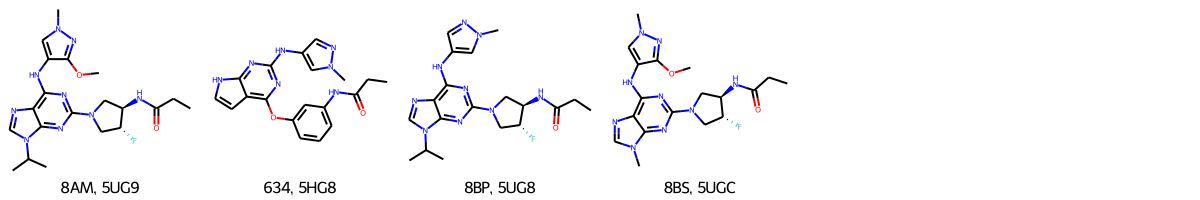

In [25]:
PandasTools.AddMoleculeColumnToFrame(ligands, "smiles")
Draw.MolsToGridImage(
    mols=list(ligands.ROMol),
    legends=list(ligands["@chemicalID"] + ", " + ligands["@structureId"]),
    molsPerRow=top_num,
)

In [ ]:
### Create protein-ligand ID pairs

In [26]:
pairs = collections.OrderedDict(zip(ligands["@structureId"], ligands["@chemicalID"]))
pairs

OrderedDict([('5UG9', '8AM'),
             ('5HG8', '634'),
             ('5UG8', '8BP'),
             ('5UGC', '8BS')])

In [ ]:
### Align PDB structures and extract ligands

In [27]:
# Download PDB structures
structures = [Structure.from_pdbid(pdb_id) for pdb_id in pairs]
structures

[<Universe with 2664 atoms>,
 <Universe with 2716 atoms>,
 <Universe with 2632 atoms>,
 <Universe with 2542 atoms>]

In [28]:
### Extract protein and ligand to remove solvent and other artifacts of crystallography
complexes = [
    Structure.from_atomgroup(structure.select_atoms(f"protein or resname {ligand}"))
    for structure, ligand in zip(structures, pairs.values())
]
complexes

[<Universe with 2330 atoms>,
 <Universe with 2491 atoms>,
 <Universe with 2319 atoms>,
 <Universe with 2320 atoms>]

In [31]:
# Write complex to file
for complex_, pdb_id in zip(complexes, pairs.keys()):
    complex_.write(DATA / f"{pdb_id}.pdb")

In [ ]:
### Align proteins

In [32]:
results = align(complexes, method=METHODS["mda"])

AttributeError: module 'Bio' has no attribute 'Alphabet'

In [ ]:
# Visualize out aligned protein-ligand complexes

In [34]:
view = nglview.NGLWidget()
for complex_ in complexes:
    view.add_component(complex_.atoms)
view

view.render_image(trim=True, factor=2, transparent=True);
view._display_image()

In [ ]:
### Extract ligands

In [37]:
ligands = [
    Structure.from_atomgroup(complex_.select_atoms(f"resname {ligand}"))
    for complex_, ligand in zip(complexes, pairs.values())
]
ligands

[<Universe with 32 atoms>,
 <Universe with 28 atoms>,
 <Universe with 30 atoms>,
 <Universe with 30 atoms>]

In [38]:
for ligand, pdb_id in zip(ligands, pairs.keys()):
    ligand.write(DATA / f"{pdb_id}_lig.pdb")

In [ ]:
### Check the existence of all ligand pdb files

In [39]:
ligand_files = []
for file in DATA.glob("*_lig.pdb"):
    ligand_files.append(file.name)
ligand_files

['5UG9_lig.pdb', '5HG8_lig.pdb', '5UG8_lig.pdb', '5UGC_lig.pdb']

In [40]:
view = nglview.NGLWidget()
for component_id, ligand in enumerate(ligands):
    view.add_component(ligand.atoms)
    view.remove_ball_and_stick(component=component_id)
    view.add_licorice(component=component_id)
view

view.render_image(trim=True, factor=2, transparent=True);

view._display_image()